<a href="https://colab.research.google.com/github/Namaswi24/Lung-Segmentation/blob/main/Pulmonary_Chest_X_Ray_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path

# ============================================================================
# UPDATED PATH FOR GOOGLE DRIVE
# ============================================================================
DATASET_PATH = "/content/drive/MyDrive/Lung Segmentation"
# ============================================================================

class DatasetExplorer:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        # Note: This script checks 'ClinicalReadings', but your main images
        # are in 'CXR_png'. The find_pairs method correctly checks both.
        self.images_folder = self.dataset_path / "ClinicalReadings"
        self.masks_folder = self.dataset_path / "masks"
        self.cxr_png_folder = self.dataset_path / "CXR_png"

        self.images = []
        self.masks = []

    def explore_structure(self):
        """Check what's in your dataset folders"""
        print("\n" + "="*70)
        print("EXPLORING YOUR DATASET STRUCTURE")
        print("="*70)

        folders = {
            "ClinicalReadings": self.images_folder,
            "masks": self.masks_folder,
            "CXR_png": self.cxr_png_folder
        }

        for name, path in folders.items():
            if path.exists():
                # Check for .png, .jpg, and .jpeg files
                files = list(path.glob("*.png")) + list(path.glob("*.jpg")) + list(path.glob("*.jpeg"))
                print(f"\n✓ {name}/ folder found: {len(files)} files")
                if files:
                    print(f"  Example: {files[0].name}")
            else:
                print(f"\n✗ {name}/ folder NOT found at {path}")

    def find_pairs(self):
        """Find matching image-mask pairs"""
        print("\n" + "="*70)
        print("FINDING IMAGE-MASK PAIRS")
        print("="*70)

        image_files = []

        # Prefer CXR_png (main chest X-rays)
        if self.cxr_png_folder.exists():
            image_files += list(self.cxr_png_folder.glob("*.png")) + list(self.cxr_png_folder.glob("*.jpg"))

        # Optionally include ClinicalReadings (if contains images)
        if self.images_folder.exists():
            image_files += list(self.images_folder.glob("*.png")) + list(self.images_folder.glob("*.jpg"))

        if len(image_files) == 0:
            print("ERROR: No image files found in either CXR_png or ClinicalReadings!")
            return [], []

        print(f"Found {len(image_files)} total images to check.")

        # Match with masks
        for img_path in image_files:
            img_name = img_path.stem

            # Check for common mask naming conventions
            mask_candidates = [
                self.masks_folder / f"{img_name}.png",
                self.masks_folder / f"{img_name}_mask.png",
                self.masks_folder / f"{img_name}_masks.png"
            ]

            for mask_path in mask_candidates:
                if mask_path.exists():
                    self.images.append(str(img_path))
                    self.masks.append(str(mask_path))
                    break # Stop once we find a match

        print(f"✓ Matched {len(self.images)} image-mask pairs")

        # Check for any masks that didn't get matched
        total_masks = len(list(self.masks_folder.glob("*.png")))
        if total_masks > len(self.images):
            unmatched_masks = total_masks - len(self.images)
            print(f"⚠️  {unmatched_masks} masks do not have matching images (or use a different naming scheme).")

        if len(self.images) == 0:
            print("\n⚠️ WARNING: No pairs found!")
            print("Check if filenames match between images and masks folders")

        return self.images, self.masks

    def analyze_dimensions(self):
        """Check image sizes"""
        if len(self.images) == 0:
            return None

        print("\n" + "="*70)
        print("ANALYZING IMAGE DIMENSIONS")
        print("="*70)

        sample_size = min(20, len(self.images))
        heights, widths = [], []

        for i in range(sample_size):
            img = cv2.imread(self.images[i])
            if img is not None:
                h, w = img.shape[:2]
                heights.append(h)
                widths.append(w)

        print(f"Sampled {sample_size} images:")
        print(f"  Height: {min(heights)} to {max(heights)} (avg: {int(np.mean(heights))})")
        print(f"  Width:  {min(widths)} to {max(widths)} (avg: {int(np.mean(widths))})")

        # Recommend size
        max_dim = max(max(heights), max(widths))
        if max_dim <= 256:
            target = 128
        elif max_dim <= 512:
            target = 256
        else:
            target = 512

        print(f"\n💡 Recommended training size: {target}x{target}")

        return target

    def visualize(self):
        """Show sample images"""
        if len(self.images) < 3:
            print("\nNot enough samples to visualize.")
            return

        print("\n" + "="*70)
        print("CREATING VISUALIZATION")
        print("="*70)

        fig, axes = plt.subplots(3, 3, figsize=(12, 12))

        # Get 3 random samples
        sample_indices = np.random.choice(len(self.images), 3, replace=False)

        for idx, i in enumerate(sample_indices):
            img = cv2.imread(self.images[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.masks[i], cv2.IMREAD_GRAYSCALE)

            # Resize for consistent viewing
            img_display = cv2.resize(img, (256, 256))
            mask_display = cv2.resize(mask, (256, 256))

            overlay = img_display.copy()
            overlay[mask_display > 127] = [255, 0, 0] # red overlay on mask

            axes[idx, 0].imshow(img_display)
            axes[idx, 0].set_title(f'Image: {Path(self.images[i]).name}')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(mask_display, cmap='gray')
            axes[idx, 1].set_title(f'Mask: {Path(self.masks[i]).name}')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(overlay)
            axes[idx, 2].set_title(f'Overlay')
            axes[idx, 2].axis('off')

        plt.tight_layout()
        plt.savefig('dataset_preview.png', dpi=150)
        print("✓ Saved visualization to: dataset_preview.png")
        print("  (Check the file panel on the left to view it)")
        plt.close()


def main():
    print("\n" + "="*70)
    print("🏥 CHEST X-RAY DATASET EXPLORER FOR MEDT")
    print("="*70)

    # Check if we're in Colab and the Drive is mounted
    if not Path("/content/drive/MyDrive").exists():
        print("⚠️ Google Drive not mounted. Please mount your drive first.")
        print("from google.colab import drive")
        print("drive.mount('/content/drive')")
        return

    explorer = DatasetExplorer(DATASET_PATH)

    explorer.explore_structure()
    images, masks = explorer.find_pairs()

    if len(images) > 0:
        target_size = explorer.analyze_dimensions()
        explorer.visualize()

        print("\n" + "="*70)
        print("✅ EXPLORATION COMPLETE!")
        print("="*70)
        print(f"\n📊 SUMMARY:")
        print(f"   Total pairs found: {len(images)}")
        print(f"   Recommended size: {target_size}x{target_size}")
        print(f"\n📁 OUTPUT:")
        print(f"   - dataset_preview.png (check the file panel!)")
        print(f"\n🚀 NEXT STEP:")
        print(f"   Use the {len(images)} paired 'images' and 'masks' lists")
        print(f"   to create your MedTDataset class for training.")
        print("="*70)
    else:
        print("\n" + "="*70)
        print("❌ NO DATA FOUND")
        print("="*70)
        print("\nPlease check:")
        print(f"1. Is DATASET_PATH correct? (Current: {DATASET_PATH})")
        print("2. Do 'CXR_png' and 'masks' folders exist at that path?")
        print("3. Do image and mask filenames match (e.g., 'img1.png' and 'img1_mask.png')?")

# This makes the script run when you execute the cell
if __name__ == "__main__":
    main()


🏥 CHEST X-RAY DATASET EXPLORER FOR MEDT

EXPLORING YOUR DATASET STRUCTURE

✓ ClinicalReadings/ folder found: 0 files

✓ masks/ folder found: 705 files
  Example: CHNCXR_0107_0_mask.png

✓ CXR_png/ folder found: 800 files
  Example: CHNCXR_0007_0.png

FINDING IMAGE-MASK PAIRS
Found 800 total images to check.
✓ Matched 704 image-mask pairs
⚠️  1 masks do not have matching images (or use a different naming scheme).

ANALYZING IMAGE DIMENSIONS
Sampled 20 images:
  Height: 2320 to 2959 (avg: 2864)
  Width:  2306 to 3000 (avg: 2878)

💡 Recommended training size: 512x512

CREATING VISUALIZATION
✓ Saved visualization to: dataset_preview.png
  (Check the file panel on the left to view it)

✅ EXPLORATION COMPLETE!

📊 SUMMARY:
   Total pairs found: 704
   Recommended size: 512x512

📁 OUTPUT:
   - dataset_preview.png (check the file panel!)

🚀 NEXT STEP:
   Use the 704 paired 'images' and 'masks' lists
   to create your MedTDataset class for training.


In [ ]:
import torch

# Define the path to the checkpoint file
checkpoint_path = "/content/drive/MyDrive/MedT_Lung_Output/best_medt_model.pth"

# Load the checkpoint
try:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    print(f"Successfully loaded checkpoint from: {checkpoint_path}\n")
    print("Contents of the checkpoint:")
    for key in checkpoint.keys():
        print(f"- {key}")

    # You can access specific components like this:
    # model_state_dict = checkpoint['model_state_dict']
    # best_dice = checkpoint['best_dice']

except FileNotFoundError:
    print(f"Error: Checkpoint file not found at {checkpoint_path}")
except Exception as e:
    print(f"An error occurred while loading the checkpoint: {e}")


🚀 TRAINING MEDICAL TRANSFORMER (MEDT) - FULL METRICS
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Matching image-mask pairs...
✅ Found 704 image-mask pairs

Train: 492 | Val: 106 | Test: 106

Model parameters: 2,248,209

Epoch 1/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [01:09<00:00,  2.59s/it]


Train -> Loss: 0.4731, Dice: 0.7897, Acc: 0.8371, Prec: 0.7058, Rec: 0.9541
Val   -> Loss: 0.3808, Dice: 0.9123, IoU: 0.8393, Acc: 0.9525, Prec: 0.8608, Rec: 0.9713

✅ Saved best model (Epoch: 1, Dice: 0.9123)

Epoch 2/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Train -> Loss: 0.3371, Dice: 0.9343, Acc: 0.9663, Prec: 0.9119, Rec: 0.9589
Val   -> Loss: 0.3292, Dice: 0.9228, IoU: 0.8570, Acc: 0.9587, Prec: 0.8846, Rec: 0.9652

✅ Saved best model (Epoch: 2, Dice: 0.9228)

Epoch 3/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Train -> Loss: 0.2938, Dice: 0.9415, Acc: 0.9702, Prec: 0.9255, Rec: 0.9593
Val   -> Loss: 0.2760, Dice: 0.9465, IoU: 0.8987, Acc: 0.9722, Prec: 0.9338, Rec: 0.9599

✅ Saved best model (Epoch: 3, Dice: 0.9465)

Epoch 4/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Train -> Loss: 0.2572, Dice: 0.9489, Acc: 0.9739, Prec: 0.9374, Rec: 0.9615
Val   -> Loss: 0.2532, Dice: 0.9428, IoU: 0.8926, Acc: 0.9705, Prec: 0.9316, Rec: 0.9551

Epoch 5/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Train -> Loss: 0.2283, Dice: 0.9511, Acc: 0.9751, Prec: 0.9439, Rec: 0.9595
Val   -> Loss: 0.2277, Dice: 0.9362, IoU: 0.8812, Acc: 0.9663, Prec: 0.9156, Rec: 0.9582

Epoch 6/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.2028, Dice: 0.9539, Acc: 0.9767, Prec: 0.9491, Rec: 0.9597
Val   -> Loss: 0.1967, Dice: 0.9539, IoU: 0.9121, Acc: 0.9764, Prec: 0.9543, Rec: 0.9540

✅ Saved best model (Epoch: 6, Dice: 0.9539)

Epoch 7/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.1819, Dice: 0.9553, Acc: 0.9773, Prec: 0.9531, Rec: 0.9584
Val   -> Loss: 0.1751, Dice: 0.9517, IoU: 0.9081, Acc: 0.9752, Prec: 0.9482, Rec: 0.9557

Epoch 8/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Train -> Loss: 0.1629, Dice: 0.9576, Acc: 0.9785, Prec: 0.9557, Rec: 0.9604
Val   -> Loss: 0.1574, Dice: 0.9548, IoU: 0.9138, Acc: 0.9767, Prec: 0.9489, Rec: 0.9612

✅ Saved best model (Epoch: 8, Dice: 0.9548)

Epoch 9/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.1462, Dice: 0.9600, Acc: 0.9797, Prec: 0.9606, Rec: 0.9600
Val   -> Loss: 0.1458, Dice: 0.9549, IoU: 0.9140, Acc: 0.9767, Prec: 0.9547, Rec: 0.9554

✅ Saved best model (Epoch: 9, Dice: 0.9549)

Epoch 10/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Train -> Loss: 0.1325, Dice: 0.9611, Acc: 0.9804, Prec: 0.9622, Rec: 0.9604
Val   -> Loss: 0.1304, Dice: 0.9562, IoU: 0.9164, Acc: 0.9774, Prec: 0.9569, Rec: 0.9559

✅ Saved best model (Epoch: 10, Dice: 0.9562)

Epoch 11/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Train -> Loss: 0.1222, Dice: 0.9609, Acc: 0.9803, Prec: 0.9635, Rec: 0.9589
Val   -> Loss: 0.1238, Dice: 0.9551, IoU: 0.9144, Acc: 0.9769, Prec: 0.9557, Rec: 0.9549

Epoch 12/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.1115, Dice: 0.9624, Acc: 0.9809, Prec: 0.9649, Rec: 0.9604
Val   -> Loss: 0.1165, Dice: 0.9545, IoU: 0.9132, Acc: 0.9764, Prec: 0.9487, Rec: 0.9607

Epoch 13/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Train -> Loss: 0.1026, Dice: 0.9633, Acc: 0.9815, Prec: 0.9666, Rec: 0.9605
Val   -> Loss: 0.1059, Dice: 0.9584, IoU: 0.9205, Acc: 0.9787, Prec: 0.9633, Rec: 0.9540

✅ Saved best model (Epoch: 13, Dice: 0.9584)

Epoch 14/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0938, Dice: 0.9652, Acc: 0.9824, Prec: 0.9684, Rec: 0.9623
Val   -> Loss: 0.1035, Dice: 0.9558, IoU: 0.9156, Acc: 0.9773, Prec: 0.9575, Rec: 0.9545

Epoch 15/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Train -> Loss: 0.0876, Dice: 0.9658, Acc: 0.9827, Prec: 0.9690, Rec: 0.9632
Val   -> Loss: 0.0992, Dice: 0.9523, IoU: 0.9093, Acc: 0.9757, Prec: 0.9576, Rec: 0.9476

Epoch 16/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0820, Dice: 0.9664, Acc: 0.9831, Prec: 0.9694, Rec: 0.9638
Val   -> Loss: 0.1035, Dice: 0.9482, IoU: 0.9020, Acc: 0.9738, Prec: 0.9592, Rec: 0.9379

Epoch 17/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0823, Dice: 0.9623, Acc: 0.9809, Prec: 0.9662, Rec: 0.9588
Val   -> Loss: 0.0912, Dice: 0.9523, IoU: 0.9094, Acc: 0.9757, Prec: 0.9603, Rec: 0.9448

Epoch 18/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0748, Dice: 0.9654, Acc: 0.9825, Prec: 0.9693, Rec: 0.9621
Val   -> Loss: 0.0840, Dice: 0.9569, IoU: 0.9177, Acc: 0.9779, Prec: 0.9622, Rec: 0.9521

Epoch 19/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Train -> Loss: 0.0694, Dice: 0.9674, Acc: 0.9835, Prec: 0.9709, Rec: 0.9644
Val   -> Loss: 0.0788, Dice: 0.9591, IoU: 0.9218, Acc: 0.9792, Prec: 0.9692, Rec: 0.9497

✅ Saved best model (Epoch: 19, Dice: 0.9591)

Epoch 20/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Train -> Loss: 0.0646, Dice: 0.9689, Acc: 0.9843, Prec: 0.9720, Rec: 0.9661
Val   -> Loss: 0.0844, Dice: 0.9527, IoU: 0.9101, Acc: 0.9756, Prec: 0.9507, Rec: 0.9550

Epoch 21/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Train -> Loss: 0.0626, Dice: 0.9685, Acc: 0.9841, Prec: 0.9715, Rec: 0.9659
Val   -> Loss: 0.0805, Dice: 0.9567, IoU: 0.9175, Acc: 0.9780, Prec: 0.9662, Rec: 0.9480

Epoch 22/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Train -> Loss: 0.0572, Dice: 0.9710, Acc: 0.9854, Prec: 0.9741, Rec: 0.9683
Val   -> Loss: 0.0893, Dice: 0.9476, IoU: 0.9010, Acc: 0.9729, Prec: 0.9373, Rec: 0.9587

Epoch 23/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0546, Dice: 0.9715, Acc: 0.9856, Prec: 0.9739, Rec: 0.9693
Val   -> Loss: 0.0770, Dice: 0.9555, IoU: 0.9153, Acc: 0.9772, Prec: 0.9572, Rec: 0.9544

Epoch 24/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Train -> Loss: 0.0530, Dice: 0.9713, Acc: 0.9855, Prec: 0.9738, Rec: 0.9691
Val   -> Loss: 0.0799, Dice: 0.9530, IoU: 0.9106, Acc: 0.9758, Prec: 0.9472, Rec: 0.9594

Epoch 25/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0498, Dice: 0.9727, Acc: 0.9862, Prec: 0.9750, Rec: 0.9707
Val   -> Loss: 0.0734, Dice: 0.9557, IoU: 0.9156, Acc: 0.9773, Prec: 0.9596, Rec: 0.9522

Epoch 26/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Train -> Loss: 0.0483, Dice: 0.9725, Acc: 0.9861, Prec: 0.9749, Rec: 0.9703
Val   -> Loss: 0.0722, Dice: 0.9565, IoU: 0.9170, Acc: 0.9779, Prec: 0.9614, Rec: 0.9522

Epoch 27/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0475, Dice: 0.9721, Acc: 0.9859, Prec: 0.9748, Rec: 0.9695
Val   -> Loss: 0.0721, Dice: 0.9550, IoU: 0.9144, Acc: 0.9769, Prec: 0.9564, Rec: 0.9541

Epoch 28/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0447, Dice: 0.9738, Acc: 0.9867, Prec: 0.9758, Rec: 0.9720
Val   -> Loss: 0.0689, Dice: 0.9574, IoU: 0.9186, Acc: 0.9782, Prec: 0.9602, Rec: 0.9551

Epoch 29/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Train -> Loss: 0.0442, Dice: 0.9736, Acc: 0.9866, Prec: 0.9760, Rec: 0.9713
Val   -> Loss: 0.0686, Dice: 0.9574, IoU: 0.9186, Acc: 0.9783, Prec: 0.9646, Rec: 0.9507

Epoch 30/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0411, Dice: 0.9747, Acc: 0.9872, Prec: 0.9771, Rec: 0.9724
Val   -> Loss: 0.0688, Dice: 0.9558, IoU: 0.9158, Acc: 0.9776, Prec: 0.9665, Rec: 0.9458

Epoch 31/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0392, Dice: 0.9758, Acc: 0.9878, Prec: 0.9776, Rec: 0.9742
Val   -> Loss: 0.0698, Dice: 0.9555, IoU: 0.9153, Acc: 0.9773, Prec: 0.9593, Rec: 0.9523

Epoch 32/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0382, Dice: 0.9767, Acc: 0.9882, Prec: 0.9787, Rec: 0.9748
Val   -> Loss: 0.0691, Dice: 0.9563, IoU: 0.9167, Acc: 0.9776, Prec: 0.9595, Rec: 0.9536

Epoch 33/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0364, Dice: 0.9777, Acc: 0.9887, Prec: 0.9792, Rec: 0.9764
Val   -> Loss: 0.0700, Dice: 0.9568, IoU: 0.9176, Acc: 0.9779, Prec: 0.9607, Rec: 0.9535

Epoch 34/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Train -> Loss: 0.0361, Dice: 0.9778, Acc: 0.9888, Prec: 0.9795, Rec: 0.9762
Val   -> Loss: 0.0693, Dice: 0.9564, IoU: 0.9168, Acc: 0.9777, Prec: 0.9593, Rec: 0.9540

Epoch 35/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]


Train -> Loss: 0.0352, Dice: 0.9780, Acc: 0.9889, Prec: 0.9795, Rec: 0.9766
Val   -> Loss: 0.0690, Dice: 0.9564, IoU: 0.9167, Acc: 0.9778, Prec: 0.9611, Rec: 0.9522

Epoch 36/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Train -> Loss: 0.0349, Dice: 0.9783, Acc: 0.9890, Prec: 0.9799, Rec: 0.9768
Val   -> Loss: 0.0705, Dice: 0.9558, IoU: 0.9158, Acc: 0.9774, Prec: 0.9590, Rec: 0.9531

Epoch 37/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0331, Dice: 0.9791, Acc: 0.9894, Prec: 0.9805, Rec: 0.9777
Val   -> Loss: 0.0698, Dice: 0.9564, IoU: 0.9168, Acc: 0.9777, Prec: 0.9586, Rec: 0.9547

Epoch 38/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Train -> Loss: 0.0326, Dice: 0.9793, Acc: 0.9896, Prec: 0.9806, Rec: 0.9781
Val   -> Loss: 0.0697, Dice: 0.9566, IoU: 0.9171, Acc: 0.9779, Prec: 0.9632, Rec: 0.9506

Epoch 39/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Train -> Loss: 0.0327, Dice: 0.9791, Acc: 0.9895, Prec: 0.9808, Rec: 0.9775
Val   -> Loss: 0.0714, Dice: 0.9550, IoU: 0.9142, Acc: 0.9770, Prec: 0.9593, Rec: 0.9512

Epoch 40/40
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Train -> Loss: 0.0305, Dice: 0.9803, Acc: 0.9900, Prec: 0.9816, Rec: 0.9790
Val   -> Loss: 0.0692, Dice: 0.9568, IoU: 0.9174, Acc: 0.9779, Prec: 0.9613, Rec: 0.9528

📊 Saved full training history to /content/drive/MyDrive/MedT_Lung_Output/training_history_full.png

Evaluating best model on test set...


Validation: 100%|██████████| 27/27 [01:00<00:00,  2.24s/it]



📊 FINAL TEST SET RESULTS
  Loss:      0.0792
  Dice:      0.9556
  IoU:       0.9155
  Accuracy:  0.9791
  Precision: 0.9709
  Recall:    0.9411
✓ Saved predictions to /content/drive/MyDrive/MedT_Lung_Output/test_predictions.png

🎉 Training Complete! All results saved.



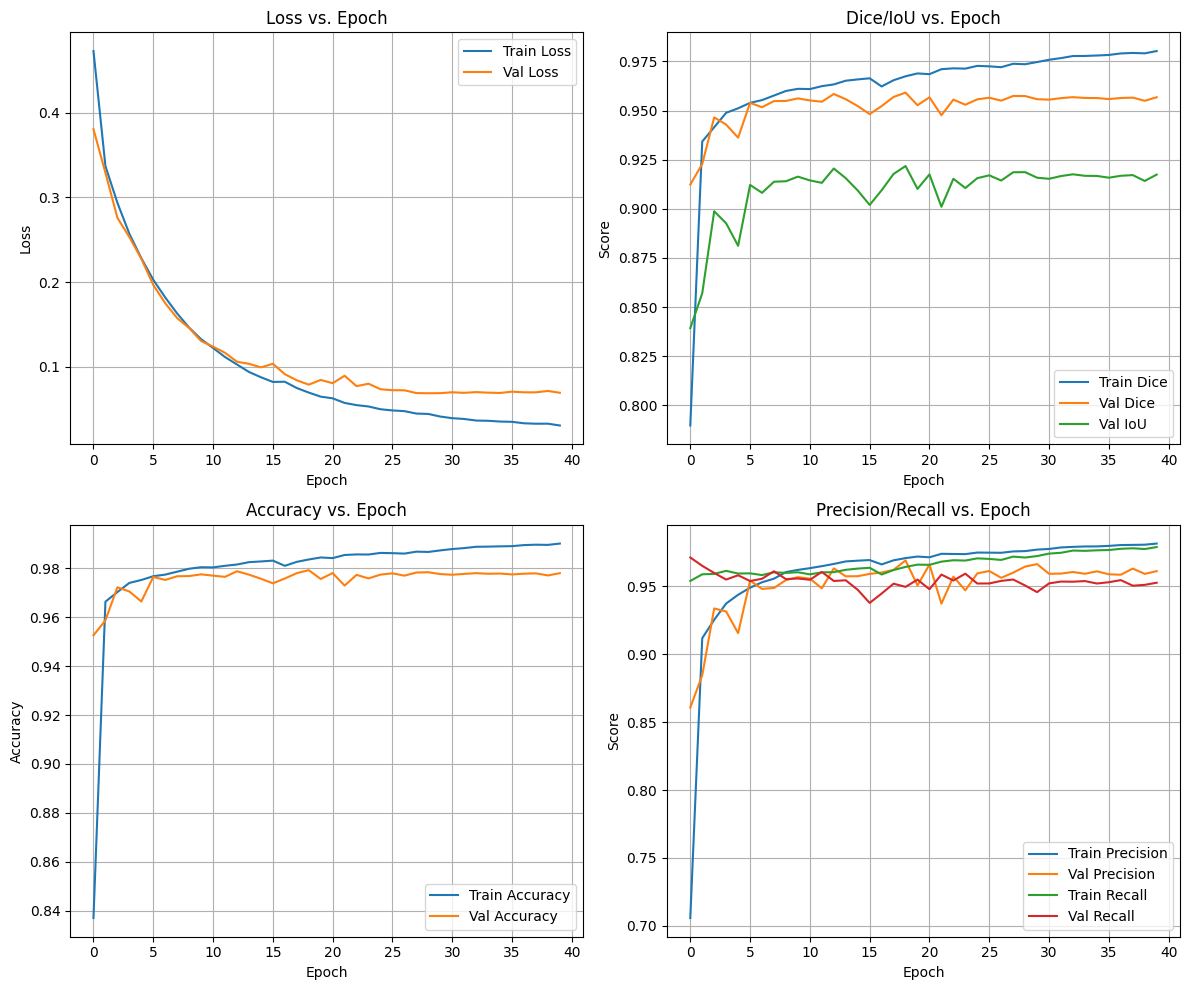

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os

# ============================================================================
# MedT MODEL ARCHITECTURE
# (This is identical to your provided code)
# ============================================================================

class GatedAxialAttention(nn.Module):
    """Gated Axial Attention with learnable gates (Equation 3 from paper)"""

    def __init__(self, dim, num_heads=8, axis='width', max_size=128):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.axis = axis
        self.scale = self.head_dim ** -0.5
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)
        self.pos_query = nn.Parameter(torch.randn(1, num_heads, max_size, self.head_dim))
        self.pos_key = nn.Parameter(torch.randn(1, num_heads, max_size, self.head_dim))
        self.pos_value = nn.Parameter(torch.randn(1, num_heads, max_size, self.head_dim))
        self.gate_query = nn.Parameter(torch.ones(1))
        self.gate_key = nn.Parameter(torch.ones(1))
        self.gate_value1 = nn.Parameter(torch.ones(1))
        self.gate_value2 = nn.Parameter(torch.ones(1))

    def forward(self, x):
        B, C, H, W = x.shape
        if self.axis == 'width':
            x = x.permute(0, 2, 3, 1)
            x_flat = x.reshape(B * H, W, C)
            dim_len = W
        else:
            x = x.permute(0, 3, 2, 1)
            x_flat = x.reshape(B * W, H, C)
            dim_len = H
        q = self.q_proj(x_flat).reshape(-1, dim_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k_proj(x_flat).reshape(-1, dim_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x_flat).reshape(-1, dim_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        pos_q = self.pos_query[:, :, :dim_len, :]
        pos_k = self.pos_key[:, :, :dim_len, :]
        pos_v = self.pos_value[:, :, :dim_len, :]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn + (q @ (self.gate_query * pos_q).transpose(-2, -1)) * self.scale
        attn = attn + ((k @ (self.gate_key * pos_k).transpose(-2, -1)).transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = attn @ (self.gate_value1 * v + self.gate_value2 * pos_v)
        out = out.permute(0, 2, 1, 3).reshape(-1, dim_len, C)
        out = self.out_proj(out)
        if self.axis == 'width':
            out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        else:
            out = out.reshape(B, W, H, C).permute(0, 3, 2, 1)
        return out

class GatedAxialTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.GroupNorm(1, dim)
        self.norm2 = nn.GroupNorm(1, dim)
        self.norm3 = nn.GroupNorm(1, dim)
        self.height_attn = GatedAxialAttention(dim, num_heads, axis='height')
        self.width_attn = GatedAxialAttention(dim, num_heads, axis='width')
        self.ffn = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.GELU(),
            nn.Conv2d(dim * 4, dim, 1)
        )
    def forward(self, x):
        x = x + self.height_attn(self.norm1(x))
        x = x + self.width_attn(self.norm2(x))
        x = x + self.ffn(self.norm3(x))
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class MedT(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, img_size=128):
        super().__init__()
        base = 32
        self.g_enc1 = ConvBlock(in_channels, base)
        self.g_pool1 = nn.MaxPool2d(2)
        self.g_enc2 = ConvBlock(base, base * 2)
        self.g_pool2 = nn.MaxPool2d(2)
        self.g_transformer = nn.Sequential(
            *[GatedAxialTransformerBlock(base * 2, 4) for _ in range(2)]
        )
        self.l_enc1 = ConvBlock(in_channels, base)
        self.l_pool1 = nn.MaxPool2d(2)
        self.l_enc2 = ConvBlock(base, base * 2)
        self.l_pool2 = nn.MaxPool2d(2)
        self.l_enc3 = ConvBlock(base * 2, base * 4)
        self.l_pool3 = nn.MaxPool2d(2)
        self.l_transformer = nn.Sequential(
            *[GatedAxialTransformerBlock(base * 4, 8) for _ in range(4)]
        )
        self.dec3 = nn.ConvTranspose2d(base * 4, base * 2, 2, stride=2)
        self.dec_conv3 = ConvBlock(base * 4, base * 2)
        self.dec2 = nn.ConvTranspose2d(base * 2, base, 2, stride=2)
        self.dec_conv2 = ConvBlock(base * 2, base)
        self.dec1 = nn.ConvTranspose2d(base, base, 2, stride=2)
        self.dec_conv1 = ConvBlock(base, base)
        self.final = nn.Conv2d(base, num_classes, 1)
        self.g_conv = nn.Conv2d(base * 2, base * 4, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        g1 = self.g_enc1(x)
        g1p = self.g_pool1(g1)
        g2 = self.g_enc2(g1p)
        g2p = self.g_pool2(g2)
        g_feat = self.g_transformer(g2p)
        patch_size = H // 4
        patches = []
        for i in range(4):
            for j in range(4):
                patch = x[:, :, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
                l1 = self.l_enc1(patch)
                l1p = self.l_pool1(l1)
                l2 = self.l_enc2(l1p)
                l2p = self.l_pool2(l2)
                l3 = self.l_enc3(l2p)
                l3p = self.l_pool3(l3)
                l_feat = self.l_transformer(l3p)
                patches.append(l_feat)
        rows = [torch.cat(patches[i * 4:(i + 1) * 4], dim=3) for i in range(4)]
        l_features = torch.cat(rows, dim=2)
        target_spatial = l_features.shape[2:]
        g_up = F.interpolate(g_feat, size=target_spatial, mode='bilinear', align_corners=False)
        if g_up.shape[1] != l_features.shape[1]:
            g_up = self.g_conv(g_up)
        merged = l_features + g_up
        d3 = self.dec3(merged)
        g2_resized = F.interpolate(g2, size=d3.shape[2:], mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, g2_resized], dim=1)
        d3 = self.dec_conv3(d3)
        d2 = self.dec2(d3)
        g1_resized = F.interpolate(g1, size=d2.shape[2:], mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, g1_resized], dim=1)
        d2 = self.dec_conv2(d2)
        d1 = self.dec1(d2)
        d1 = self.dec_conv1(d1)
        out = self.final(d1)
        return torch.sigmoid(out)

# ============================================================================
# CONFIGURATION
# ============================================================================
DATASET_PATH = "/content/drive/MyDrive/Lung Segmentation"
OUTPUT_DIR = "/content/drive/MyDrive/MedT_Lung_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 128
BATCH_SIZE = 4
EPOCHS = 40
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SMOOTH = 1e-6 # Epsilon for smoothing to avoid division by zero

# ============================================================================
# DATASET
# (This is identical to your provided code)
# ============================================================================
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(str(self.image_paths[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))

        mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.float32)

        if self.augment and np.random.rand() > 0.5:
            if np.random.rand() > 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)
            if np.random.rand() > 0.5:
                factor = 0.8 + np.random.rand() * 0.4
                img = np.clip(img * factor, 0, 255).astype(np.uint8)

        img = img.astype(np.float32) / 255.0
        img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

        img = torch.from_numpy(img).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return img, mask

# ============================================================================
# METRICS, TRAINING, VALIDATION, VISUALIZATION
# ============================================================================

# --- METRIC FUNCTIONS (UPDATED) ---

def dice_coefficient(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2.0 * intersection + SMOOTH) / (pred.sum() + target.sum() + SMOOTH)

def iou_score(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + SMOOTH) / (union + SMOOTH)

# --- NEW METRIC FUNCTIONS ---
def accuracy_score(pred, target):
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = target.numel() # Total number of pixels
    return correct / total

def precision_score(pred, target):
    pred = (pred > 0.5).float()
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum() # Predicted positive, actual negative
    return (tp + SMOOTH) / (tp + fp + SMOOTH)

def recall_score(pred, target):
    pred = (pred > 0.5).float()
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum() # Predicted negative, actual positive
    return (tp + SMOOTH) / (tp + fn + SMOOTH)

# --- TRAINING & VALIDATION FUNCTIONS (UPDATED) ---

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_dice, total_acc, total_prec, total_rec = 0, 0, 0, 0, 0

    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics for this batch
        dice = dice_coefficient(outputs, masks)
        acc = accuracy_score(outputs, masks)
        prec = precision_score(outputs, masks)
        rec = recall_score(outputs, masks)

        # Add to totals
        total_loss += loss.item()
        total_dice += dice.item()
        total_acc += acc.item()
        total_prec += prec.item()
        total_rec += rec.item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                          'dice': f'{dice.item():.4f}',
                          'acc': f'{acc.item():.4f}'})

    n = len(loader)
    return total_loss/n, total_dice/n, total_acc/n, total_prec/n, total_rec/n

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, total_dice, total_iou, total_acc, total_prec, total_rec = 0, 0, 0, 0, 0, 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Validation'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Calculate all metrics
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = accuracy_score(outputs, masks)
            prec = precision_score(outputs, masks)
            rec = recall_score(outputs, masks)

            # Add to totals
            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou.item()
            total_acc += acc.item()
            total_prec += prec.item()
            total_rec += rec.item()

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n, total_acc/n, total_prec/n, total_rec/n

def visualize_predictions(model, test_loader, device, save_path='predictions.png'):
    model.eval()
    images, masks = next(iter(test_loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)

    n = min(4, len(images))
    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
    if n == 1: axes = axes.reshape(1, -1)

    for i in range(n):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input'); axes[i, 0].axis('off')
        axes[i, 1].imshow(masks[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')
        axes[i, 2].imshow(outputs[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('Prediction'); axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"✓ Saved predictions to {save_path}")

# ============================================================================
# MAIN TRAINING LOOP (UPDATED)
# ============================================================================
def main():
    print("\n" + "="*70)
    print("🚀 TRAINING MEDICAL TRANSFORMER (MEDT) - FULL METRICS")
    print("="*70)

    # Mount drive if in Colab
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except ImportError:
        print("Not in a Colab environment, skipping drive mount.")

    dataset_path = Path(DATASET_PATH)
    images_folder = dataset_path / "CXR_png"
    masks_folder = dataset_path / "masks"

    print("Matching image-mask pairs...")
    image_files = list(images_folder.glob("*.png")) + list(images_folder.glob("*.jpg"))
    images, masks = [], []
    for img_path in image_files:
        mask_path = masks_folder / f"{img_path.stem}.png"
        if not mask_path.exists(): mask_path = masks_folder / f"{img_path.stem}_mask.png"
        if mask_path.exists():
            images.append(str(img_path))
            masks.append(str(mask_path))

    print(f"✅ Found {len(images)} image-mask pairs\n")
    if len(images) == 0:
        print("❌ ERROR: No data found! Please check folder names and mask filenames.")
        return

    indices = np.arange(len(images))
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

    train_images, train_masks = [images[i] for i in train_idx], [masks[i] for i in train_idx]
    val_images, val_masks = [images[i] for i in val_idx], [masks[i] for i in val_idx]
    test_images, test_masks = [images[i] for i in test_idx], [masks[i] for i in test_idx]

    print(f"Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}\n")

    train_loader = DataLoader(ChestXrayDataset(train_images, train_masks, IMG_SIZE, augment=True), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(ChestXrayDataset(val_images, val_masks, IMG_SIZE, augment=False), batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(ChestXrayDataset(test_images, test_masks, IMG_SIZE, augment=False), batch_size=BATCH_SIZE, shuffle=False)

    model = MedT(in_channels=3, num_classes=1, img_size=IMG_SIZE).to(DEVICE)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}\n")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5)

    best_dice, best_epoch = 0.0, 0

    # Updated history dictionary
    history = {
        'train_loss': [], 'train_dice': [], 'train_acc': [], 'train_prec': [], 'train_rec': [],
        'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_acc': [], 'val_prec': [], 'val_rec': []
    }

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}\n" + "-"*70)

        # Updated function calls
        train_loss, train_dice, train_acc, train_prec, train_rec = train_one_epoch(
            model, train_loader, criterion, optimizer, DEVICE
        )
        val_loss, val_dice, val_iou, val_acc, val_prec, val_rec = validate(
            model, val_loader, criterion, DEVICE
        )

        scheduler.step(val_dice)

        # Append all metrics to history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_acc'].append(train_acc)
        history['train_prec'].append(train_prec)
        history['train_rec'].append(train_rec)

        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)

        # Updated print statements
        print(f"Train -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, Acc: {train_acc:.4f}, "
              f"Prec: {train_prec:.4f}, Rec: {train_rec:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}, "
              f"Prec: {val_prec:.4f}, Rec: {val_rec:.4f}\n")

        if val_dice > best_dice:
            best_dice = val_dice
            best_epoch = epoch + 1
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(), 'best_dice': best_dice},
                       os.path.join(OUTPUT_DIR, 'best_medt_model.pth'))
            print(f"✅ Saved best model (Epoch: {best_epoch}, Dice: {best_dice:.4f})\n")

    # --- UPDATED PLOTTING (2x2 Grid) ---
    plt.figure(figsize=(12, 10))

    # Subplot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Subplot 2: Dice/IoU
    plt.subplot(2, 2, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title("Dice/IoU vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    # Subplot 3: Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title("Accuracy vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Subplot 4: Precision/Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['train_prec'], label='Train Precision')
    plt.plot(history['val_prec'], label='Val Precision')
    plt.plot(history['train_rec'], label='Train Recall')
    plt.plot(history['val_rec'], label='Val Recall')
    plt.title("Precision/Recall vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "training_history_full.png"), dpi=150)
    print(f"📊 Saved full training history to {os.path.join(OUTPUT_DIR, 'training_history_full.png')}")

    # --- UPDATED FINAL TEST EVALUATION ---
    print("\nEvaluating best model on test set...")
    checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'best_medt_model.pth'), map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_dice, test_iou, test_acc, test_prec, test_rec = validate(
        model, test_loader, criterion, DEVICE
    )

    print("\n" + "="*50)
    print("📊 FINAL TEST SET RESULTS")
    print("="*50)
    print(f"  Loss:      {test_loss:.4f}")
    print(f"  Dice:      {test_dice:.4f}")
    print(f"  IoU:       {test_iou:.4f}")
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall:    {test_rec:.4f}")
    print("="*50)

    visualize_predictions(model, test_loader, DEVICE, os.path.join(OUTPUT_DIR, 'test_predictions.png'))
    print("\n🎉 Training Complete! All results saved.\n")

if __name__ == "__main__":
    main()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# ============================================================
# 1. CONFIGURATION: PLEASE CHECK THESE PATHS
# ============================================================

# --- Path to your saved model ---
# This can be on Google Drive or Kaggle's output
# Example for Google Drive:
MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/MedT_Lung_Output/best_medt_model.pth"
# Example for Kaggle:
# MODEL_CHECKPOINT_PATH = "/kaggle/working/MedT_Lung_Output/best_medt_model.pth"


# --- Path to your test images (from your screenshot) ---
# Example for Google Drive:
INPUT_IMAGE_DIR = "/content/drive/MyDrive/Lung Segmentation/test"
# Example for Kaggle:
# INPUT_IMAGE_DIR = "/kaggle/input/your-test-set/test"


# --- Where to save the predicted masks ---
# Example for Google Drive:
PREDICTION_OUTPUT_DIR = "/content/drive/MyDrive/MedT_Lung_Output/test_predictions"
# Example for Kaggle:
# PREDICTION_OUTPUT_DIR = "/kaggle/working/test_predictions"


# --- Model Parameters (must match training) ---
IMG_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
os.makedirs(PREDICTION_OUTPUT_DIR, exist_ok=True)
print(f"Saving predictions to: {PREDICTION_OUTPUT_DIR}")

# Mount drive if in Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not in a Colab environment, skipping drive mount.")


# ============================================================
# 2. MODEL DEFINITION
# (Must be identical to your training script to load the weights)
# ============================================================

class GatedAxialAttention(nn.Module):
    def __init__(self, dim, num_heads=8, axis='width', max_size=128):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.axis = axis
        self.scale = self.head_dim ** -0.5
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)
        self.pos_query = nn.Parameter(torch.randn(1, num_heads, max_size, self.head_dim))
        self.pos_key = nn.Parameter(torch.randn(1, num_heads, max_size, self.head_dim))
        self.pos_value = nn.Parameter(torch.randn(1, num_heads, max_size, self.head_dim))
        self.gate_query = nn.Parameter(torch.ones(1))
        self.gate_key = nn.Parameter(torch.ones(1))
        self.gate_value1 = nn.Parameter(torch.ones(1))
        self.gate_value2 = nn.Parameter(torch.ones(1))

    def forward(self, x):
        B, C, H, W = x.shape
        if self.axis == 'width':
            x = x.permute(0, 2, 3, 1)
            x_flat = x.reshape(B * H, W, C)
            dim_len = W
        else:
            x = x.permute(0, 3, 2, 1)
            x_flat = x.reshape(B * W, H, C)
            dim_len = H
        q = self.q_proj(x_flat).reshape(-1, dim_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k_proj(x_flat).reshape(-1, dim_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(x_flat).reshape(-1, dim_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        pos_q = self.pos_query[:, :, :dim_len, :]
        pos_k = self.pos_key[:, :, :dim_len, :]
        pos_v = self.pos_value[:, :, :dim_len, :]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn + (q @ (self.gate_query * pos_q).transpose(-2, -1)) * self.scale
        attn = attn + ((k @ (self.gate_key * pos_k).transpose(-2, -1)).transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = attn @ (self.gate_value1 * v + self.gate_value2 * pos_v)
        out = out.permute(0, 2, 1, 3).reshape(-1, dim_len, self.dim)
        out = self.out_proj(out)
        if self.axis == 'width':
            out = out.reshape(B, H, W, self.dim).permute(0, 3, 1, 2)
        else:
            out = out.reshape(B, W, H, self.dim).permute(0, 3, 2, 1)
        return out

class GatedAxialTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.norm1 = nn.GroupNorm(1, dim); self.norm2 = nn.GroupNorm(1, dim); self.norm3 = nn.GroupNorm(1, dim)
        self.height_attn = GatedAxialAttention(dim, num_heads, axis='height')
        self.width_attn = GatedAxialAttention(dim, num_heads, axis='width')
        self.ffn = nn.Sequential(nn.Conv2d(dim, dim * 4, 1), nn.GELU(), nn.Conv2d(dim * 4, dim, 1))
    def forward(self, x):
        x = x + self.height_attn(self.norm1(x)); x = x + self.width_attn(self.norm2(x)); x = x + self.ffn(self.norm3(x))
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class MedT(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, img_size=128):
        super().__init__()
        base = 32
        self.g_enc1 = ConvBlock(in_channels, base); self.g_pool1 = nn.MaxPool2d(2)
        self.g_enc2 = ConvBlock(base, base * 2); self.g_pool2 = nn.MaxPool2d(2)
        self.g_transformer = nn.Sequential(*[GatedAxialTransformerBlock(base * 2, 4) for _ in range(2)])
        self.l_enc1 = ConvBlock(in_channels, base); self.l_pool1 = nn.MaxPool2d(2)
        self.l_enc2 = ConvBlock(base, base * 2); self.l_pool2 = nn.MaxPool2d(2)
        self.l_enc3 = ConvBlock(base * 2, base * 4); self.l_pool3 = nn.MaxPool2d(2)
        self.l_transformer = nn.Sequential(*[GatedAxialTransformerBlock(base * 4, 8) for _ in range(4)])
        self.dec3 = nn.ConvTranspose2d(base * 4, base * 2, 2, stride=2)
        self.dec_conv3 = ConvBlock(base * 4, base * 2)
        self.dec2 = nn.ConvTranspose2d(base * 2, base, 2, stride=2)
        self.dec_conv2 = ConvBlock(base * 2, base)
        self.dec1 = nn.ConvTranspose2d(base, base, 2, stride=2)
        self.dec_conv1 = ConvBlock(base, base)
        self.final = nn.Conv2d(base, num_classes, 1)
        self.g_conv = nn.Conv2d(base * 2, base * 4, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        g1 = self.g_enc1(x); g2 = self.g_enc2(self.g_pool1(g1)); g_feat = self.g_transformer(self.g_pool2(g2))
        patch_size = H // 4
        patches = []
        for i in range(4):
            for j in range(4):
                patch = x[:, :, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                l_feat = self.l_transformer(self.l_pool3(self.l_enc3(self.l_pool2(self.l_enc2(self.l_pool1(self.l_enc1(patch)))))))
                patches.append(l_feat)
        rows = [torch.cat(patches[i*4:(i+1)*4], dim=3) for i in range(4)]; l_features = torch.cat(rows, dim=2)
        g_up = F.interpolate(g_feat, size=l_features.shape[2:], mode='bilinear', align_corners=False)
        g_up = self.g_conv(g_up) if g_up.shape[1] != l_features.shape[1] else g_up
        merged = l_features + g_up
        d3 = self.dec3(merged); d3 = self.dec_conv3(torch.cat([d3, F.interpolate(g2, size=d3.shape[2:], mode='bilinear', align_corners=False)], dim=1))
        d2 = self.dec2(d3); d2 = self.dec_conv2(torch.cat([d2, F.interpolate(g1, size=d2.shape[2:], mode='bilinear', align_corners=False)], dim=1))
        d1 = self.dec_conv1(self.dec1(d2))
        # Return logits (raw output), as our model was trained with BCEWithLogitsLoss
        return self.final(d1)


# ============================================================
# 3. PREDICTION-ONLY DATASET
# (This only loads images, not masks)
# ============================================================

class PredictionDataset(Dataset):
    def __init__(self, image_paths, img_size):
        self.image_paths = image_paths
        self.img_size = img_size
        # Normalization constants (must match training)
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get image path
        img_path = str(self.image_paths[idx])

        # Load Image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize (while keeping original for saving later if needed, but not necessary here)
        img_resized = cv2.resize(img, (self.img_size, self.img_size))

        # Normalize Image
        img_norm = img_resized.astype(np.float32) / 255.0
        img_norm = (img_norm - self.mean) / self.std

        # Convert to Tensor
        img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).float()

        # Return the tensor and the original image's filename
        return img_tensor, self.image_paths[idx].name

# ============================================================
# 4. MAIN INFERENCE SCRIPT
# ============================================================

def run_predictions():
    print("🚀 Starting prediction...")

    # --- 1. Load Model ---
    model = MedT(in_channels=3, num_classes=1, img_size=IMG_SIZE).to(DEVICE)

    try:
        # Load the weights. If you saved the full state dict:
        checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=DEVICE)

        # Check if it's a state_dict or a full checkpoint
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint) # Assumes it's just the state_dict

        print(f"✅ Model loaded successfully from: {MODEL_CHECKPOINT_PATH}")
    except Exception as e:
        print(f"❌ ERROR loading model: {e}")
        print("Please check the MODEL_CHECKPOINT_PATH.")
        return

    model.eval() # Set model to evaluation mode (very important!)

    # --- 2. Load Test Data ---
    print(f"Loading images from: {INPUT_IMAGE_DIR}")
    image_folder = Path(INPUT_IMAGE_DIR)

    # Find all .png, .jpg, .jpeg images
    image_paths = list(image_folder.glob("*.png")) + \
                  list(image_folder.glob("*.jpg")) + \
                  list(image_folder.glob("*.jpeg"))

    if len(image_paths) == 0:
        print(f"❌ ERROR: No images found in {INPUT_IMAGE_DIR}")
        return

    print(f"✅ Found {len(image_paths)} images to predict.")

    pred_dataset = PredictionDataset(image_paths, IMG_SIZE)
    pred_loader = DataLoader(pred_dataset, batch_size=4, shuffle=False)

    # --- 3. Run Prediction Loop ---
    print("Generating predictions...")
    with torch.no_grad():
        for images, filenames in tqdm(pred_loader, desc="Predicting"):
            images = images.to(DEVICE)

            # Get model outputs (logits)
            logits = model(images)

            # Convert logits to probabilities (0-1)
            probs = torch.sigmoid(logits)

            # Convert probabilities to binary mask (0 or 255)
            preds = (probs > 0.5).cpu().numpy().astype(np.uint8) * 255

            # Save each mask in the batch
            for i in range(len(filenames)):
                mask = preds[i].squeeze() # Remove batch and channel dims
                filename = filenames[i]

                # We need to resize the mask back up to the original image size
                # But since we don't know the original size, we'll save as IMG_SIZE
                # Or, even better, we can resize to a standard output size like 512x512

                mask_resized = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

                save_path = os.path.join(PREDICTION_OUTPUT_DIR, f"{Path(filename).stem}_mask.png")
                cv2.imwrite(save_path, mask_resized)

    print("\n" + "="*50)
    print("🎉 PREDICTION COMPLETE! 🎉")
    print("="*50)
    print(f"All predicted masks have been saved to:")
    print(f"{PREDICTION_OUTPUT_DIR}")

# --- Run the prediction script ---
if __name__ == "__main__":
    run_predictions()

Using device: cuda
Saving predictions to: /content/drive/MyDrive/MedT_Lung_Output/test_predictions
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Starting prediction...
✅ Model loaded successfully from: /content/drive/MyDrive/MedT_Lung_Output/best_medt_model.pth
Loading images from: /content/drive/MyDrive/Lung Segmentation/test
✅ Found 96 images to predict.
Generating predictions...


Predicting: 100%|██████████| 24/24 [01:55<00:00,  4.83s/it]


🎉 PREDICTION COMPLETE! 🎉
All predicted masks have been saved to:
/content/drive/MyDrive/MedT_Lung_Output/test_predictions
